# <font color='#f78fb3'> Netflix Recommendations System - Word2Vec  |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  Transfer Learning, using Google Pretrained Data
3.  Create Word2Vec Model
4.  Content based Recommendation System; Find 'what to watch' based which you movie you watched <br>

## <font color='#f9ca24'> Word Embedding
 <font color='00BFEB'>

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
#!pip install gensim #Install gensim, a useful NLP library that we will use to load w2v embeddings
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors
import warnings  
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
# warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim')  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font color='#f78fb3'>Load data 

In [2]:
data=pd.read_csv('netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [3]:
data.description.count()

6234

In [4]:
data.description[0]

'Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.'

In [5]:
data.title[0]

'Norm of the North: King Sized Adventure'

### <font color='#f78fb3'>only show columns of interest

In [6]:
df=data[['title','description','listed_in']]
df.head(2)

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy


In [7]:
df.isnull().sum()

title          0
description    0
listed_in      0
dtype: int64

### <font color='#f78fb3'>Visualize the length of descriptions

In [8]:
df['word_count']=df['description'].apply(lambda x: len(x.split()))
df['word_count']

0       23
1       25
2       23
3       20
4       26
        ..
6229    24
6230    24
6231    21
6232    23
6233    24
Name: word_count, Length: 6234, dtype: int64

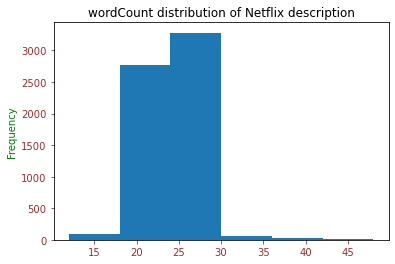

In [9]:
ax=df['word_count'].plot(
kind='hist',bins=6,title='wordCount distribution of Netflix description')
ax.yaxis.label.set_color('green')
ax.xaxis.label.set_color('green')
ax.tick_params(axis='x',colors='brown')
ax.tick_params(axis='y',colors='brown')

<font color='#3dc1d3'> Ensure Descriptions only contain strings; not float dtyp; Pandas astype() is the one of the most important methods. It is used to change data type of a series. When data frame is made from a csv file, the columns are imported and data type is set automatically which many times is not what it actually should have. For example, a salary column could be imported as string but to do operations we have to convert it into float. In this case, the series in description column; the dtype needs to be converted to string, ensure it is not float
astype() is used to do such data type conversions.

In [10]:
df['desciption']=df['description'].astype(str)

 ### <font color='#f9ca24'> Preprocessing (cleaning) the Descriptions. <br>
 <font color='#3dc1d3'> Non-ASCII characters: भारत hindi;
.网络 Chinese; Hebrew
.קום, Arabic <br> Ascii - english based letters/digits/

In [17]:
import re
def prepocessing(text):
    text=[i.lower() for i in text if ord(i)<128]
    text=''.join(text)
    text=text.split()
    stops=set(stopwords.words('english'))
    text=[i for i in text if not i in stops ]
    text=' '.join(text)
    token=RegexpTokenizer(r'\w+')
    text=token.tokenize(text)
    text=' '.join(text)
    html=re.compile('<.*?>')
    text=html.sub('',text)
    return text

In [18]:
data['prepocessed_desc']=data['description'].apply(lambda x:prepocessing(x))

 <font color='#3dc1d3'>A new column is created to store the cleaned, preprocessed descriptions.

In [19]:
data.prepocessed_desc

0       planning awesome wedding grandfather polar bea...
1       jandino asporaat riffs challenges raising kids...
2       help three human allies autobots protect earth...
3       prison ship crash unleashes hundreds deceptico...
4       nerdy high schooler dani finally attracts inte...
                              ...                        
6229    parody first person shooter games military lif...
6230    marc maron stars marc maron interviews fellow ...
6231    nursery rhymes original music children accompa...
6232    set russian revolution comic miniseries based ...
6233    hit sitcom follows merry misadventures six 20 ...
Name: prepocessed_desc, Length: 6234, dtype: object

<font color='#f9ca24'>Start Work on the Word2Vec Model<br><font color='#f78fb3'>Splitting the descriptions into words and stored in a list called ‘universe’; universe is essentially our corpus used for training our word2vec model<br>The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.<br><font color='#f78fb3'>Word tokenization; break up description into word chunks

In [ ]:
universe=[]
for words in data['prepocessed_desc']:
    universe.append(words.split())

<font color='#f9ca24'>Transfer Learning<br><font color='#f78fb3'>using the word2vec pre-trained Google News model (GoogleNews-vectors-negative300) with the gensim Python library.<br>get GoogleNews pretrained data<br> takes a few seconds to load in gensim

In [22]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

'wget' is not recognized as an internal or external command,
operable program or batch file.


<font color='#f78fb3'>embedding_file as the GoogleNews-vectors-negative300 file

In [23]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

<font color='#f78fb3'>Training corpus with Google Pretrained Model 

<font color='#f78fb3'>Above: intersect_word2vec_format() <br>Merge the input-hidden weight matrix from the original word2vec format given, where it intersects with the current vocabulary/universe corpus. (What you need to note here: No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.)<br>binary is a boolean indicating whether the data is in binary word2vec format.<br>lockf is a lock-factor value to be set for any imported word-vectors; the default value of 0.0 prevents further updating of the vector during subsequent training. Use 1.0 to allow further training updates of merged vectors.<br>
<br>
The parameters:
min_count =  Ignores all words with total absolute frequency lower than this - (2, 100)<br>
window = The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)<br>
size = int - Dimensionality of the feature vectors. - (50, 300)<br>
sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5) <br> 
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)<br>
Word2Vec needs a vocabulary; (taking in the tokens and filtering out the unique ones

<font color='#3dc1d3'>Try out the similarity between words; after intersecting with our corpus-universe

<font color='#f78fb3'>The function Vectorize() defines the average word2vec for each Netflix description

<font color='#f78fb3'>define the function to find the top 5 most similar/recommended Netflix shows, based on the one you previously watched.<br>Invert index; we have a dictionary of characters/embeddings from Description mapped to their titles, and we want to convert that to a dictionary of titles mapped to the characters that have them.<br> We trained on the descriptions of the Netflix shows but we want to search/match based on a title. 

<font color='#f9ca24'> Netflix Recommendations 

In [16]:
netflix_because_you_watched("Transformers Prime")

NameError: name 'netflix_because_you_watched' is not defined

In [ ]:
netflix_because_you_watched("Friends")